# Imports

In [1]:
import keras
from keras.models import Sequential, Model
from keras.layers import BatchNormalization, Input, Embedding, SpatialDropout1D, concatenate, Merge
from keras.layers.core import Flatten, Dense, Dropout, Lambda
from keras.optimizers import Adam
import numpy as np
import pandas as pd
import gc
import os
import cyclic
os.environ['OMP_NUM_THREADS'] = '4'

/home/callum/anaconda2/envs/dl/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# Set the path of the data
# PATH = "~/.kaggle/competitions/talkingdata-adtracking-fraud-detection"
PATH = "../data/talkingdata"
SCRATCH_PATH = "/scratch/brown/g1082124/talkingdata"

In [3]:
# Import dataset
#train = pd.read_csv(PATH + "/train_1_4.csv")
train = None

# Preprocessing

In [4]:
#train.head()

In [5]:
cat_vars = ["app", "device", "os", "channel", "hour", "day", "wday"]

In [6]:
# Method for getting data in a format that keras can work worth
def getKerasData(dataset):
    X = {
        'app': np.array(dataset.app),
        #'ip': np.array(dataset.ip),
        'device': np.array(dataset.device),
        'os': np.array(dataset.os),
        'channel': np.array(dataset.channel),
        'hour': np.array(dataset.hour),
        'day': np.array(dataset.day),
        'wday': np.array(dataset.wday),
        'qty': np.array(dataset.wday),
        'ip_app_count': np.array(dataset.ip_app_count),
        'ip_app_os_count': np.array(dataset.ip_app_os_count),
    }
    return X

In [7]:
# Method for changing the train dataset, e.g. changing which quarter of the set to use
def changeDataset(fname):
    #del train#, X_train, y_train, X_valid, y_valid; gc.collect()
    global X_train, y_train, X_valid, y_valid, idx_split
    train = pd.read_csv(PATH + "/" + fname)
    
    idx_split = int(len(train) * .75)

    X_train = getKerasData(train.iloc[:idx_split])
    y_train = train["is_attributed"].iloc[:idx_split].values

    X_valid = getKerasData(train.iloc[idx_split:])
    y_valid = train["is_attributed"].iloc[idx_split:].values
    del train
    gc.collect()
    

In [18]:
#changeDataset('train_3_4.csv')

# On to the Model

### Setup Model

In [9]:
# Get Nums of Unique Values (max value + 1)
#max_ip = 333168
max_app = 730
max_device = 3799
max_os = 856
max_channel = 202
max_hour = 24
max_day = 5
max_wday = 5
max_qty = 44260
max_c1 = 220744


In [10]:
# Define the inputs and embedding layers
emb_szs = emb_n = 50
dense_szs = 1024

in_app = Input(shape=[1], name="app")
emb_app = Embedding(max_app, emb_szs)(in_app)
#in_ip = Input(shape=[1], name="ip")
#emb_ip = Embedding(max_ip, emb_szs)(in_ip)
in_device = Input(shape=[1], name="device")
emb_device = Embedding(max_device, 70)(in_device)
in_os = Input(shape=[1], name="os")
emb_os = Embedding(max_os, emb_szs)(in_os)
in_channel = Input(shape=[1], name="channel")
emb_channel = Embedding(max_channel, emb_szs)(in_channel)
in_hour = Input(shape=[1], name="hour")
emb_hour = Embedding(max_hour, 16)(in_hour)
in_day = Input(shape=[1], name="day")
emb_day = Embedding(max_day, 16)(in_day)
in_wday = Input(shape=[1], name="wday")
emb_wday = Embedding(max_wday, 16)(in_wday)
in_qty = Input(shape=[1], name="qty")
emb_qty = Embedding(max_qty, emb_szs)(in_qty)
in_c1 = Input(shape=[1], name="ip_app_count")
emb_c1 = Embedding(max_c1, emb_szs)(in_c1)
in_c2 = Input(shape=[1], name="ip_app_os_count")
emb_c2 = Embedding(max_c1, emb_szs)(in_c2)

#embs = concatenate([(emb_app), (emb_ip), (emb_device), (emb_os), (emb_channel)])
embs = concatenate([(emb_app), (emb_device), (emb_os), (emb_channel), (emb_hour),
                   (emb_day), (emb_wday), (emb_qty), (emb_c1), (emb_c2)])

# Now turn those into dense layers
s_dout = SpatialDropout1D(0.4)(embs)
x = Flatten()(s_dout)
x = Dropout(0.4)(Dense(dense_szs, activation="relu")(x))
x = BatchNormalization()(x)
x = Dropout(0.4)(Dense(dense_szs, activation="relu")(x))
x = BatchNormalization()(x)
output = Dense(1, activation="sigmoid")(x)

#model = Model(inputs=[in_app,in_channel,in_device,in_os,in_ip], outputs=output)
model = Model(inputs=[in_app,in_channel,in_device,in_os,in_hour,
                     in_day,in_wday,in_qty,in_c1,in_c2], outputs=output)

In [11]:
# Learning Rate Decay
bs = 70000
epochs = 1
# exp_decay = lambda init, fin, steps: (init/fin)**(1/(steps-1)) - 1
# steps = int(idx_split / bs) * epochs
# lr_init, lr_fin = 0.003, 0.0002
# lr_decay = exp_decay(lr_init, lr_fin, steps)
#optimizer_adam = Adam(lr=0.0005, decay=lr_decay)
optimizer_adam = Adam(lr=.0001)

In [12]:
clr = cyclic.CyclicLR(base_lr=.0001, max_lr=.001, step_size=2000, mode="triangular2")

In [13]:
model.compile(loss='binary_crossentropy',optimizer=optimizer_adam,metrics=['accuracy'])

In [14]:
#model.summary()
model.load_weights('../models/talkingdata_4epoch.h5')

### ROC Callback

In [15]:
# ROC Curve
from sklearn.metrics import roc_auc_score
class roc_callback(keras.callbacks.Callback):
    def __init__(self,training_data,validation_data):
        self.x = training_data[0]
        self.y = training_data[1]
        self.x_val = validation_data[0]
        self.y_val = validation_data[1]


    def on_train_begin(self, logs={}):
        return

    def on_train_end(self, logs={}):
        return

    def on_epoch_begin(self, epoch, logs={}):
        return

    def on_epoch_end(self, epoch, logs={}):
        y_pred = self.model.predict(self.x, batch_size=bs, verbose=2)
        roc = roc_auc_score(self.y, y_pred)
        #roc = 1
        y_pred_val = self.model.predict(self.x_val, batch_size=bs, verbose=2)
        roc_val = roc_auc_score(self.y_val, y_pred_val)
        print('\rroc-auc: %s - roc-auc_val: %s' % (str(round(roc,4)),str(round(roc_val,4))),end=100*' '+'\n')
        return

    def on_batch_begin(self, batch, logs={}):
        return

    def on_batch_end(self, batch, logs={}):
        return

### Model Training

In [16]:
#About .02% of the dataset is positive, class weights make up for that
#class_weight = {0:.0002,1:.9998}
class_weight = {0: .0015, 1:.99}

In [36]:
from random import shuffle
l = list(range(1, 5))
shuffle(l)

for n in l:
    print('Working on split {}'.format(n))
    changeDataset('train_{}_4.csv'.format(n))
    callbacks=[roc_callback(training_data=(X_train, y_train),validation_data=(X_valid, y_valid)),
          clr]
    model.fit(X_train, y_train, batch_size=bs, validation_data=(X_valid, y_valid), epochs=epochs,
          class_weight=class_weight, callbacks=callbacks)

Working on split 2
Train on 34669479 samples, validate on 11556494 samples
Epoch 1/1
34669479/34669479 [==============================] - 308s 9us/step - loss: 6.3714e-04 - acc: 0.9376 - val_loss: 0.2173 - val_acc: 0.9299
roc-auc: 0.9835 - roc-auc_val: 0.9766                                                                                                    
Working on split 1
Train on 34669479 samples, validate on 11556493 samples
Epoch 1/1
34669479/34669479 [==============================] - 305s 9us/step - loss: 7.7020e-04 - acc: 0.9259 - val_loss: 0.2197 - val_acc: 0.9331
roc-auc: 0.9771 - roc-auc_val: 0.9743                                                                                                    
Working on split 3
Train on 34669479 samples, validate on 11556493 samples
Epoch 1/1
34669479/34669479 [==============================] - 302s 9us/step - loss: 6.5449e-04 - acc: 0.9507 - val_loss: 0.1889 - val_acc: 0.9488
roc-auc: 0.9809 - roc-auc_val: 0.9698                     

In [30]:
model.fit(X_train, y_train, batch_size=bs, validation_data=(X_valid, y_valid), epochs=epochs,
          class_weight=class_weight, callbacks=callbacks)

Train on 34669479 samples, validate on 11556494 samples
Epoch 1/1
34669479/34669479 [==============================] - 306s 9us/step - loss: 9.4774e-04 - acc: 0.9060 - val_loss: 0.2186 - val_acc: 0.9509
roc-auc: 0.9688 - roc-auc_val: 0.9721                                                                                                    


In [38]:
model.save("../models/talkingdata_8epoch.h5")

# Model Evaluation

### Confusion Matrix Visualization Method

In [42]:
import matplotlib.pyplot as plt
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

### Find Confusion Matrix

In [39]:
# test = train.iloc[int(len(train)*.75):]
# print(len(test))
# X_test = getKerasData(test)
# y_test = test["is_attributed"].values
# y_pred = model.predict(X_test, batch_size=bs, verbose=2)
y_pred = model.predict(X_valid, batch_size=bs, verbose=2)
roc = roc_auc_score(y_valid, y_pred)
print(roc)

0.9795156240087143


In [40]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_valid, np.round(y_pred))

Normalized confusion matrix
[[0.95948078 0.04051922]
 [0.07610674 0.92389326]]


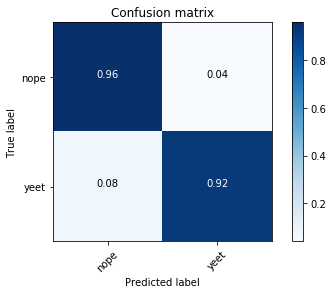

In [43]:
plot_confusion_matrix(cm, ["nope", "yeet"], normalize=True)

# Generate Submission

In [45]:
import gc
del X_train, X_valid, y_train, y_valid; gc.collect()
test = pd.read_csv(PATH + "/test_proc.csv")

In [46]:
submit = pd.DataFrame()
submit['click_id'] = test['click_id'].astype('int')

In [47]:
X_test = getKerasData(test)

In [52]:
submit['is_attributed'] = model.predict(X_test, batch_size=bs, verbose=2)

In [53]:
submit.head()

,click_id,is_attributed
0,0,0.176220
1,1,0.194937
2,2,0.072726
3,3,0.078845
4,4,0.071592


In [54]:
submit.to_csv('submits/talkingdata_7epoch_submit.csv', index=False)

In [51]:
#model.load_weights('../models/talkingdata_7epoch.h5')